In [1]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


print(torch.__version__)

1.12.0+cu102


In [2]:
data = np.load('./data/alanine-dipeptide-3x250ns-heavy-atom-positions.npz')['arr_0'][:10000]

In [3]:
natoms = 10
dim = 3
data = data.reshape(-1, natoms, dim)
data -= data[:, None, 0]
data = data.reshape(-1, natoms * dim)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, input_dim=30, hidden_dim=128, latent_dim=2):
        super(VAE, self).__init__()
        
        # Encoder
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc31 = nn.Linear(hidden_dim, latent_dim)
        self.fc32 = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.fc4 = nn.Linear(latent_dim, hidden_dim)
        self.fc5 = nn.Linear(hidden_dim, hidden_dim)
        self.fc6 = nn.Linear(hidden_dim, input_dim)
        
    def encode(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc31(x), self.fc32(x)
    
    def decode(self, z):
        z = F.relu(self.fc4(z))
        z = F.relu(self.fc5(z))
        return self.fc6(z)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [5]:
# 计算VAE的损失函数，包括重构损失和KL散度
def loss_function(recon_x, x, mu, logvar):
    # 重构损失，使用二进制交叉熵
    # BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    
    # KL散度损失
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return BCE + 0.1*KLD, BCE, 0.1*KLD

In [6]:
cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

batch_size = 100

num_epochs = 10

input_dim = 30
hidden_dim = 128
latent_dim = 2

In [7]:
# 创建VAE模型实例
model = VAE(input_dim=input_dim,
            hidden_dim=hidden_dim,
            latent_dim=latent_dim).to(DEVICE)

# 定义优化器
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [8]:
print(model)

VAE(
  (fc1): Linear(in_features=30, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc31): Linear(in_features=128, out_features=2, bias=True)
  (fc32): Linear(in_features=128, out_features=2, bias=True)
  (fc4): Linear(in_features=2, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=128, bias=True)
  (fc6): Linear(in_features=128, out_features=30, bias=True)
)


In [9]:
z = torch.randn(4, 2).to(DEVICE)  # 生成一个随机潜在向量
generated_data = model.decode(z)
print(generated_data.shape)

torch.Size([4, 30])


In [10]:
from torch.utils.data import Dataset, DataLoader


class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # 获取给定索引的数据点，并将其转换为PyTorch张量
        sample = torch.Tensor(self.data[idx])
        return sample


kwargs = {'num_workers': 1, 'pin_memory': True} 

dataset = CustomDataset(data)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, **kwargs)

In [11]:
print("Start training VAE...")
model.train()

losses = []
klds = []
reproduction_losses = []

for epoch in range(num_epochs):
    overall_loss = 0
    overall_kld = 0
    overall_reproduction_loss = 0
    for batch_idx, x in enumerate(tqdm(train_loader)):
        # x = x.view(batch_size, 30)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, x_mean, x_log_var = model(x)
        loss, repro_loss, kld = loss_function(x_hat, x, x_mean, x_log_var)

        overall_loss += loss.item()
        overall_kld += kld.item()
        overall_reproduction_loss += repro_loss.item()

        loss.backward()
        optimizer.step()
    
    losses.append(overall_loss / (batch_idx*batch_size))
    klds.append(overall_kld / (batch_idx*batch_size))
    reproduction_losses.append(overall_reproduction_loss / (batch_idx*batch_size))

    print("\tEpoch", epoch+1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))

print("Finish!!")

Start training VAE...


100%|██████████| 100/100 [00:00<00:00, 144.98it/s]


	Epoch 1 complete! 	Average Loss:  0.2249268730240639


100%|██████████| 100/100 [00:00<00:00, 164.87it/s]


	Epoch 2 complete! 	Average Loss:  0.13849085644038037


100%|██████████| 100/100 [00:00<00:00, 164.93it/s]


	Epoch 3 complete! 	Average Loss:  0.13776875389946833


100%|██████████| 100/100 [00:00<00:00, 161.15it/s]


	Epoch 4 complete! 	Average Loss:  0.13701812156523116


100%|██████████| 100/100 [00:00<00:00, 143.05it/s]


	Epoch 5 complete! 	Average Loss:  0.13289385968988593


100%|██████████| 100/100 [00:00<00:00, 151.75it/s]


	Epoch 6 complete! 	Average Loss:  0.123714395484539


100%|██████████| 100/100 [00:00<00:00, 174.46it/s]


	Epoch 7 complete! 	Average Loss:  0.1225139914618598


100%|██████████| 100/100 [00:00<00:00, 135.34it/s]


	Epoch 8 complete! 	Average Loss:  0.12230942880264437


100%|██████████| 100/100 [00:00<00:00, 201.87it/s]


	Epoch 9 complete! 	Average Loss:  0.1233778839881974


100%|██████████| 100/100 [00:00<00:00, 174.66it/s]

	Epoch 10 complete! 	Average Loss:  0.12240069389343261
Finish!!


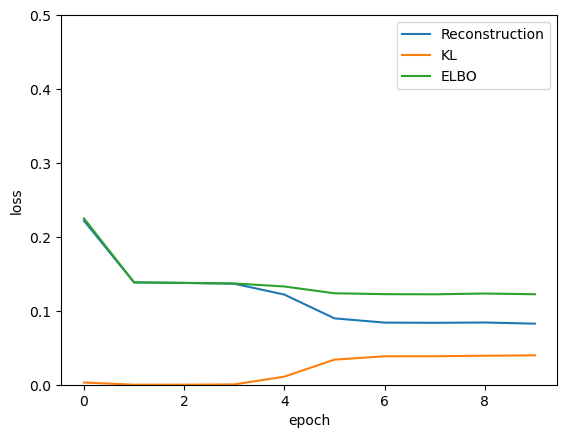

In [13]:
plt.plot(reproduction_losses, label="Reconstruction")
plt.plot(klds, label="KL")
plt.plot(losses, label="ELBO")
plt.legend()
plt.ylim(0, 0.5)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

### Visualization

In [14]:
from pysmiles import read_smiles
import networkx as nx
from matplotlib import animation

In [15]:
smiles = 'CC(=O)NC(C)C(=O)NC' # SMILES for alanine dipeptide
mol = read_smiles(smiles)
elements = nx.get_node_attributes(mol, name = "element")
color_map = ['gray','gray','red','blue','gray','gray','gray','red','blue','gray']
L = 23.222 # box length in Angstrom https://markovmodel.github.io/mdshare/ALA2/#alanine-dipeptide

In [16]:

def batch_plot(data):
    """
        Plot 10 molecules in data
    """
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6), subplot_kw={'xticks': [], 'yticks': [], 'zticks': [], 'projection': '3d'})
    for i, ax in enumerate(axes.flat):

        # 3d spring layout
        pos = dict(zip(range(10), data[i]*L))
     
        # Extract node and edge positions from the layout
        node_xyz = np.array([pos[v] for v in sorted(mol)])
        edge_xyz = np.array([(pos[u], pos[v]) for u, v in mol.edges()])

        # Plot the nodes - alpha is scaled by "depth" automatically
        ax.scatter(*node_xyz.T, s=150, ec="w", c=color_map)

        # Plot the edges
        for vizedge in edge_xyz:
            ax.plot(*vizedge.T, color="tab:gray")

    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    fig.legend(lines, labels)
    fig.tight_layout()

    # plt.close(fig)
    return fig

In [17]:

def batch_anim(data,frames=180,interval=50,degree=2):
    """
        Make animation for 10 molecules in data
        Input:
            frames: number of frames in the animation
            interval: unit ms
            degree: degree of rotation per frame
    """
    fig = batch_plot(data)
    plt.close(fig)
    
    def animate(frame):
        for ax in fig.axes:
            ax.view_init(30, frame*degree)
            # plt.pause(.001)
        return fig

    anim = animation.FuncAnimation(fig, animate, frames=frames, interval=interval)
    return anim

In [80]:
# natoms = 10     # Example number of atoms
# dim = 3         # Example dimension of each atom

# samples = torch.zeros(batch_size, natoms, dim)
# mu, sigma = model.encode(samples.view(batch_size, -1).to(DEVICE))

# print(mu.shape)
# print(sigma.shape)
# z = torch.randn(batch_size, 2).to(DEVICE)
# zs = z * sigma + mu
# sampled_data = model.decode(zs)
# sampled_data = sampled_data.cpu().detach().numpy().reshape(-1, 10, 3)

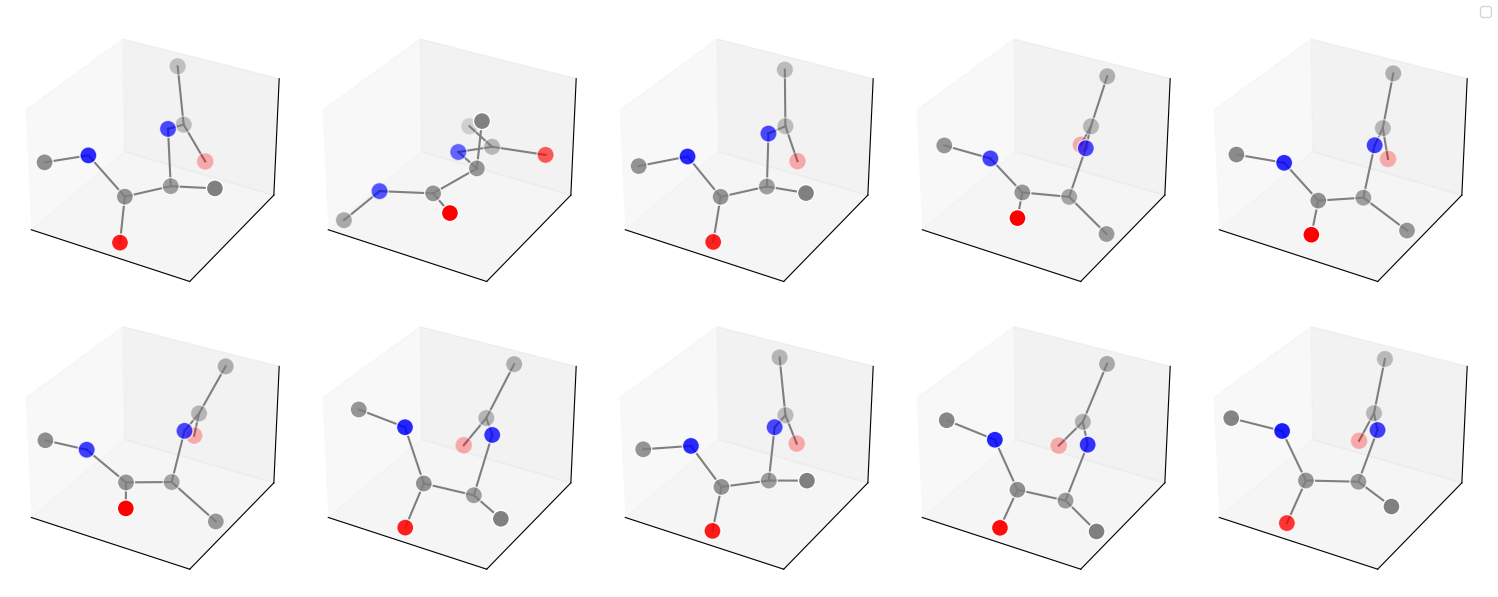

In [18]:
fig = batch_plot(data[:10].reshape(-1, 10, 3))

(10, 30)


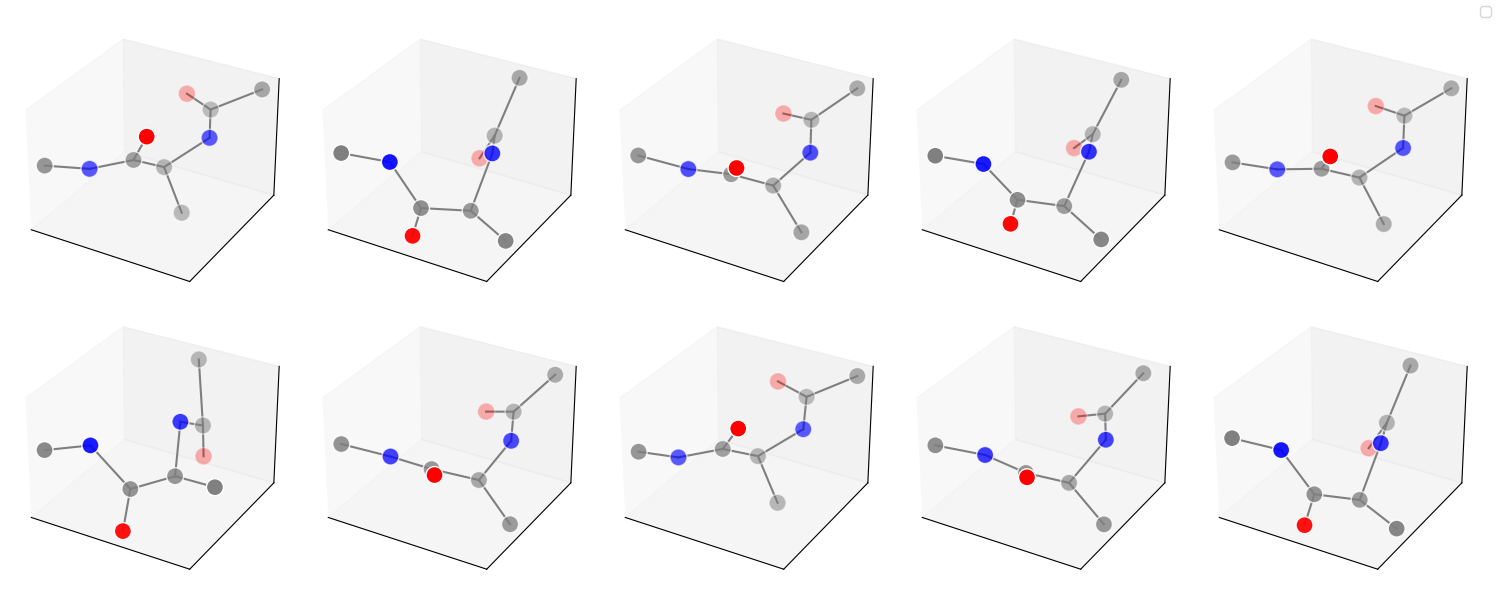

In [19]:
zs = torch.randn(10,latent_dim).to(DEVICE)
sampled_data = model.decode(zs)
sampled_data = sampled_data.cpu().detach().numpy()

print(sampled_data.shape)
sampled_data = sampled_data.reshape(-1, 10, 3)  # 10个原子，每个原子3个坐标， 画图需要reshape

# np.savez('./generated_mol.npz', arr=sampled_data)

fig = batch_plot(sampled_data)